In [126]:


from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from surprise import Reader, Dataset, SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, \
    KNNWithZScore, BaselineOnly, CoClustering, accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
init_notebook_mode(connected=True)
import numpy as np
import pandas as pd
import csv

import sklearn
from sklearn.decomposition import TruncatedSVD

columns = ['id','id2','task','TaskId','rating']
frame = pd.read_csv('DataRecommenderSystem/DataVisitVisitor.csv',sep=',', names=columns)
frame.head()

,id,id2,task,TaskId,rating
0,1,3,1000,1,6
1,2,3,1110,2,6
2,3,3,1100,3,7
3,4,3,1010,4,8
4,5,3,1000000,5,7


In [127]:
columns2 =['TaskId','TaskName','Task']
tasks = pd.read_csv('DataRecommenderSystem/TaskVisitVisitor.csv', sep=',', names = columns2, encoding='latin-1')
task_names = tasks[['TaskId','TaskName','Task']]
task_names.head()

,TaskId,TaskName,Task
0,1,Task1,1000
1,2,Task2,1110
2,3,Task3,1100
3,4,Task4,1010
4,5,Task5,1000000


In [128]:
combined_task_data = pd.merge(frame, task_names, on='TaskId')
combined_task_data.head()

,id,id2,task,TaskId,rating,TaskName,Task
0,1,3,1000,1,6,Task1,1000
1,16,3,1000,1,8,Task1,1000
2,18,3,1000,1,4,Task1,1000
3,26,3,1000,1,5,Task1,1000
4,33,3,1000,1,0,Task1,1000


In [129]:
combined_task_data.groupby('TaskId')['rating'].count().sort_values(ascending=True).head()

filter_interview = combined_task_data['TaskId']==0
combined_task_data[filter_interview]['TaskName'].unique()

array([], dtype=object)

In [130]:
rating_crosstab = combined_task_data.pivot_table(values='rating', index='id', columns=['TaskName','Task'], fill_value=0.01)
rating_crosstab

TaskName,Task1,Task10,Task11,Task2,Task3,Task4,Task5,Task6,Task7,Task8,Task9
Task,1000,1000010,1000110,1110,1100,1010,1000000,1101010,101010,100010,100110
id,,,,,,,,,,,
1,6.00,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
2,0.01,0.01,0.01,6.00,0.01,0.01,0.01,0.01,0.01,0.01,0.01
3,0.01,0.01,0.01,0.01,7.00,0.01,0.01,0.01,0.01,0.01,0.01
4,0.01,0.01,0.01,0.01,0.01,8.00,0.01,0.01,0.01,0.01,0.01
5,0.01,0.01,0.01,0.01,0.01,0.01,7.00,0.01,0.01,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...
96,0.01,0.01,0.01,0.01,4.00,0.01,0.01,0.01,0.01,0.01,0.01
97,0.01,0.01,0.01,5.00,0.01,0.01,0.01,0.01,0.01,0.01,0.01


In [131]:
rating_crosstab.shape
X = rating_crosstab.T
X.shape

(11, 100)

In [132]:
truncated_SDV = TruncatedSVD(n_components=11, random_state=0)

resultant_matrix = truncated_SDV.fit_transform(X)

resultant_matrix.shape

(11, 11)

In [133]:
corr_mat = np.corrcoef(resultant_matrix)
corr_mat.shape
task_names = rating_crosstab.columns
task_list = list(task_names)
task_list
task = task_list.index(('Task1',1000))
task
corr_1 = corr_mat[task]
corr_1.shape
corr_1

with open('DataRecommenderSystem/recommenderSystemVisit.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(corr_1)
    writer.writerow(list(task_names[(corr_1<=1) & (corr_1 > -0.09)]))



In [134]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
#add
data = frame['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / frame.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} task-ratings'.format(frame.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)
#add

In [135]:
#add
# Create trace
trace = go.Histogram(x = combined_task_data.TaskId,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 200,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Task',
                   xaxis = dict(title = 'Number of Ratings Per Task'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.1)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)
#add

#add
# Create trace
trace = go.Histogram(x = combined_task_data.id,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 200,
                                  size = 10))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.1)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)
#add

In [136]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(combined_task_data[['id', 'TaskId', 'rating']], reader)

In [137]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    print(algorithm)
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
smt = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   
print(smt)
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


{'test_rmse': array([2.35839221, 1.96513907, 2.25510759]),
 'fit_time': (0.00099945068359375,
  0.001003265380859375,
  0.0009992122650146484),
 'test_time': (0.0, 0.0, 0.0)}

In [138]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)



Estimating biases using als...
RMSE: 2.3405


2.3405354830714518

In [139]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]
print(best_predictions)
print(worst_predictions)

    uid  iid  rui       est                    details  Iu  Ui       err
2    95    7  7.0  7.108911  {'was_impossible': False}   0   3  0.108911
19   12    3  6.0  6.203046  {'was_impossible': False}   0  11  0.203046
23   14    4  7.0  7.366460  {'was_impossible': False}   0   8  0.366460
3     5    5  7.0  6.554744  {'was_impossible': False}   0   6  0.445256
13   13    5  6.0  6.554744  {'was_impossible': False}   0   6  0.554744
1    31    3  7.0  6.203046  {'was_impossible': False}   0  11  0.796954
17   64    6  6.0  6.817518  {'was_impossible': False}   0   6  0.817518
24   71    9  8.0  7.088000  {'was_impossible': False}   0   5  0.912000
0     9    9  6.0  7.088000  {'was_impossible': False}   0   5  1.088000
7    65    2  8.0  6.844721  {'was_impossible': False}   0   8  1.155279
    uid  iid   rui       est                    details  Iu  Ui       err
10   10   10   9.0  6.800000  {'was_impossible': False}   0   5  2.200000
9    86   11   5.0  7.280000  {'was_impossible': 

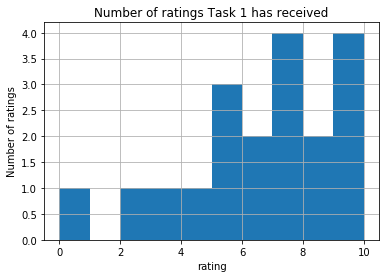

In [140]:
import matplotlib.pyplot as plt
%matplotlib inline
combined_task_data.loc[combined_task_data['TaskId'] == 1]['rating'].hist()
#fig = plt.figure()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings Task 1 has received')
plt.show();


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

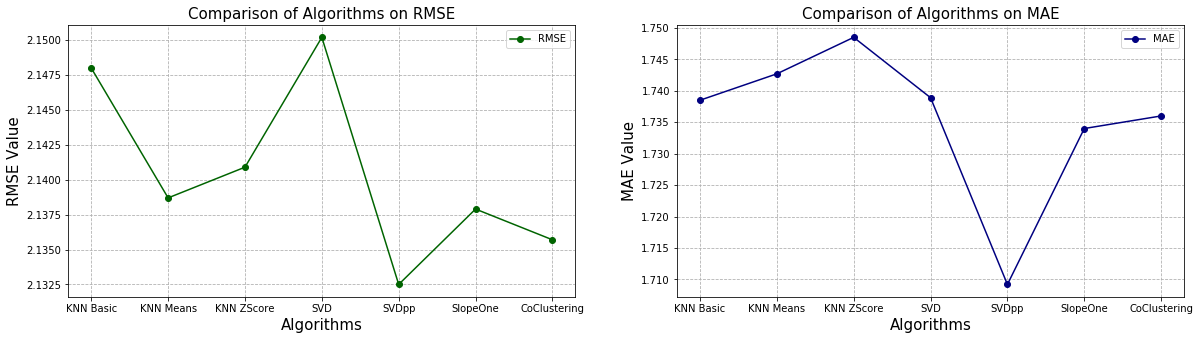

,id,id2,task,TaskId,rating
count,100.000000,100.0,1.000000e+02,100.000000,100.000000
mean,50.500000,3.0,3.347137e+05,4.770000,6.680000
std,29.011492,0.0,4.698931e+05,3.193602,2.150311
min,1.000000,3.0,1.000000e+03,1.000000,0.000000
25%,25.750000,3.0,1.010000e+03,2.000000,5.000000
50%,50.500000,3.0,1.110000e+03,4.000000,7.000000
75%,75.250000,3.0,1.000000e+06,7.000000,8.000000
max,100.000000,3.0,1.101010e+06,11.000000,10.000000


In [141]:
knnbasic_cv = cross_validate(KNNBasic(), data, cv=5, verbose=False)
knnmeans_cv = cross_validate(KNNWithMeans(), data, cv=5, verbose=False)
knnz_cv = cross_validate(KNNWithZScore(), data, cv=5, verbose=False)
svd_cv = cross_validate(SVD(), data, cv=5, verbose=False)
svdpp_cv = cross_validate(SVDpp(), data, cv=5, verbose=False)
#nmf_cv = cross_validate(NMF(), data, cv=5, n_jobs=5, verbose=False)
slope_cv = cross_validate(SlopeOne(), data, cv=5, verbose=False)
coclus_cv = cross_validate(CoClustering(), data, cv=5, verbose=False)

print('Algorithm\t RMSE\t\t MAE')
print()
print('KNN Basic', '\t', round(knnbasic_cv['test_rmse'].mean(), 4), '\t', round(knnbasic_cv['test_mae'].mean(), 4))
print('KNN Means', '\t', round(knnmeans_cv['test_rmse'].mean(), 4), '\t', round(knnmeans_cv['test_mae'].mean(), 4))
print('KNN ZScore', '\t', round(knnz_cv['test_rmse'].mean(), 4), '\t', round(knnz_cv['test_mae'].mean(), 4))
print()
print('SVD', '\t\t', round(svd_cv['test_rmse'].mean(), 4), '\t', round(svd_cv['test_mae'].mean(), 4))
print('SVDpp', '\t\t', round(svdpp_cv['test_rmse'].mean(), 4), '\t', round(svdpp_cv['test_mae'].mean(), 4))
#print('NMF', '\t\t', round(nmf_cv['test_rmse'].mean(), 4), '\t', round(nmf_cv['test_mae'].mean(), 4))
print()
print('SlopeOne', '\t', round(slope_cv['test_rmse'].mean(), 4), '\t', round(slope_cv['test_mae'].mean(), 4))
print('CoClustering', '\t', round(coclus_cv['test_rmse'].mean(), 4), '\t', round(coclus_cv['test_mae'].mean(), 4))
print()

x_algo = ['KNN Basic', 'KNN Means', 'KNN ZScore', 'SVD', 'SVDpp', 'SlopeOne', 'CoClustering']
all_algos_cv = [knnbasic_cv, knnmeans_cv, knnz_cv, svd_cv, svdpp_cv, slope_cv, coclus_cv]

rmse_cv = [round(res['test_rmse'].mean(), 4) for res in all_algos_cv]
mae_cv = [round(res['test_mae'].mean(), 4) for res in all_algos_cv]

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title('Comparison of Algorithms on RMSE', loc='center', fontsize=15)
plt.plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.subplot(1, 2, 2)
plt.title('Comparison of Algorithms on MAE', loc='center', fontsize=15)
plt.plot(x_algo, mae_cv, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()
frame.describe()

SVDpp - RMSE: 2.1357 ; MAE: 1.6972
SVD   - RMSE: 2.1807 ; MAE: 1.7371
RMSE = {'n_epochs': 25, 'lr_all': 0.007, 'reg_all': 0.6}
MAE = {'n_epochs': 25, 'lr_all': 0.01, 'reg_all': 0.4}
RMSE = {'n_epochs': 20, 'lr_all': 0.007, 'reg_all': 0.6}
MAE = {'n_epochs': 20, 'lr_all': 0.007, 'reg_all': 0.4}
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done comp

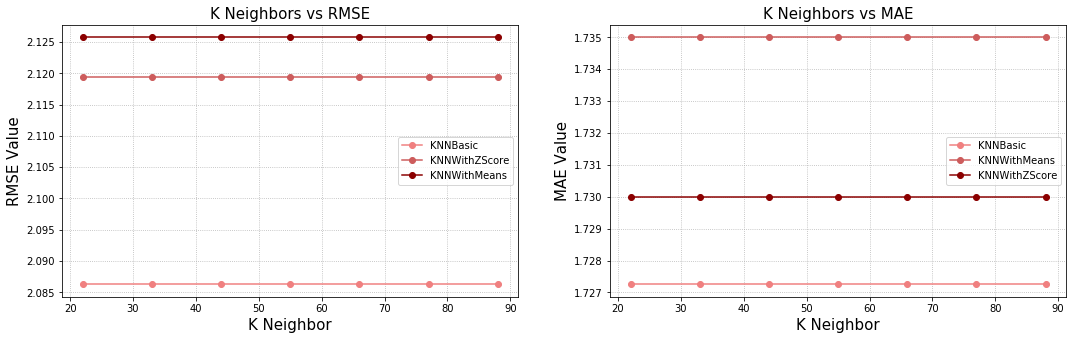

In [142]:
# Parameter space
svd_param_grid = {'n_epochs': [20, 25], 
                  'lr_all': [0.007, 0.009, 0.01],
                  'reg_all': [0.4, 0.6]}

svdpp_gs = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse', 'mae'], cv=5)
svdpp_gs.fit(data)

svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5)
svd_gs.fit(data)

print('SVDpp - RMSE:', round(svdpp_gs.best_score['rmse'], 4), '; MAE:', round(svdpp_gs.best_score['mae'], 4))
print('SVD   - RMSE:', round(svd_gs.best_score['rmse'], 4), '; MAE:', round(svd_gs.best_score['mae'], 4))
#SVDpp best params
print('RMSE =', svdpp_gs.best_params['rmse'])
print('MAE =', svdpp_gs.best_params['mae'])
#SVD best params
print('RMSE =', svd_gs.best_params['rmse'])
print('MAE =', svd_gs.best_params['mae'])

param_grid = {'k': [22, 33, 44, 55, 66, 77, 88]}

knnbasic_gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=5)
knnbasic_gs.fit(data)

knnmeans_gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=5)
knnmeans_gs.fit(data)

knnz_gs = GridSearchCV(KNNWithZScore, param_grid, measures=['rmse', 'mae'], cv=5)
knnz_gs.fit(data)

x = [22, 33, 44, 55, 66, 77, 88]
y1 = knnbasic_gs.cv_results['mean_test_rmse']
y2 = knnbasic_gs.cv_results['mean_test_mae']

y3 = knnmeans_gs.cv_results['mean_test_rmse']
y4 = knnmeans_gs.cv_results['mean_test_mae']

y5 = knnz_gs.cv_results['mean_test_rmse']
y6 = knnz_gs.cv_results['mean_test_mae']

plt.figure(figsize=(18,5))

plt.subplot(1, 2, 1)
plt.title('K Neighbors vs RMSE', loc='center', fontsize=15)
plt.plot(x, y1, label='KNNBasic', color='lightcoral', marker='o')
plt.plot(x, y5, label='KNNWithZScore', color='indianred', marker='o')
plt.plot(x, y3, label='KNNWithMeans', color='darkred', marker='o')
plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.subplot(1, 2, 2)
plt.title('K Neighbors vs MAE', loc='center', fontsize=15)
plt.plot(x, y2, label='KNNBasic', color='lightcoral', marker='o')
plt.plot(x, y4, label='KNNWithMeans', color='indianred', marker='o')
plt.plot(x, y6, label='KNNWithZScore', color='darkred', marker='o')
plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.show()
